In [1]:
#https://github.com/keras-team/keras/issues/4161#issuecomment-366031228
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import glob
from skimage.color import rgb2lab
from skimage.transform import resize
from collections import namedtuple


In [40]:
def current_name(folder, postfix):
    import time
    timestr = time.strftime("%y%m%d_%H%M%S")
    file_name = os.path.join('.',folder,timestr + postfix)
    print(file_name)
    return file_name

In [3]:
import numpy as np
import pandas as pd

In [4]:
np.random.seed(2019)
%matplotlib inline

In [5]:
import os
os.listdir("./")

['.ipynb',
 '.ipynb_checkpoints',
 '190729_resnet50_transfer.ipynb',
 '190817_preprocessing-Copy1.ipynb',
 '190817_preprocessing.ipynb',
 '190817_VGG16.ipynb',
 '190819_inception_resnet2-v1.ipynb',
 '190821_resnet.ipynb',
 'Atos2019-ver1-Copy1.ipynb',
 'Atos2019-ver1.ipynb',
 'EDA_starter_resnet50-Copy1.ipynb',
 'EDA_starter_resnet50.ipynb',
 'gpu_configProto.ipynb',
 'input',
 'Intro APTOS Diabetic Retinopathy_EDA_Starter.ipynb',
 'Keras baseline.ipynb',
 'MODEL',
 'out.png',
 'resnet50_baseline-Copy1.ipynb',
 'resnet50_baseline.ipynb',
 'save',
 'simpleCNN',
 'submission',
 'submission.csv',
 'test.png',
 'Untitled.ipynb',
 'Untitled1.ipynb',
 'WORKING']

In [8]:
os.listdir("./input/models")

['DenseNet-BC-121-32-no-top.h5',
 'DenseNet-BC-121-32.h5',
 'DenseNet-BC-161-48-no-top.h5',
 'DenseNet-BC-161-48.h5',
 'DenseNet-BC-169-32-no-top.h5',
 'DenseNet-BC-169-32.h5',
 'inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5',
 'inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5',
 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5']

In [9]:
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

In [10]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1871482270507029613
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6682591232
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16493956684494097767
physical_device_desc: "device: 0, name: GeForce GTX 1070 Ti, pci bus id: 0000:07:00.0, compute capability: 6.1"
]


In [11]:
train_dir = "./input/train_images"
df_train = pd.read_csv("./input/train.csv")
df_test = pd.read_csv("./input/test.csv")
df_train['path'] = df_train['id_code'].map(lambda x: os.path.join(train_dir, '{}.png'.format(x)))

#### EDA (Explanatory Data Analysis)

In [12]:
df = df_train
df.shape

(3662, 3)

Text(0.5, 1.0, 'Samples Per Class')

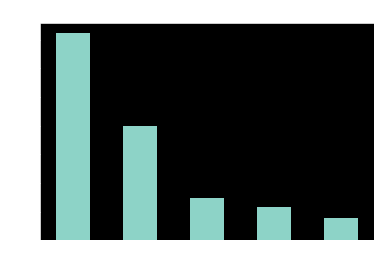

In [13]:
df['diagnosis'].value_counts().plot(kind='bar')
plt.title('Samples Per Class')

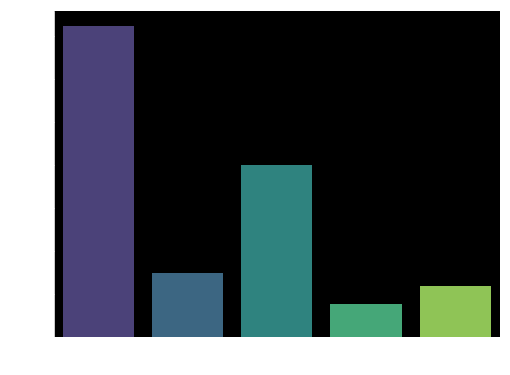

In [14]:
import seaborn as sns
f, ax = plt.subplots(figsize=(8, 6))
ax = sns.countplot(x='diagnosis', data=df_train, palette='viridis')
sns.despine()
plt.show()

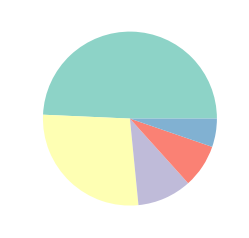

In [15]:
df['diagnosis'].value_counts().plot(kind='pie')

In [16]:
NUM_CLASSES = df_train['diagnosis'].nunique()
print(NUM_CLASSES)

5


In [17]:
df_train.head()

,id_code,diagnosis,path
0,000c1434d8d7,2,./input/train_images\000c1434d8d7.png
1,001639a390f0,4,./input/train_images\001639a390f0.png
2,0024cdab0c1e,1,./input/train_images\0024cdab0c1e.png
3,002c21358ce6,0,./input/train_images\002c21358ce6.png
4,005b95c28852,0,./input/train_images\005b95c28852.png


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3662 entries, 0 to 3661
Data columns (total 3 columns):
id_code      3662 non-null object
diagnosis    3662 non-null int64
path         3662 non-null object
dtypes: int64(1), object(2)
memory usage: 85.9+ KB


In [19]:
df_train['diagnosis']=df_train['diagnosis'].astype('str')

In [20]:
df_train['id_file'] = df_train['id_code'] + '.png'

In [21]:
os.listdir(train_dir)[0:10]

['000c1434d8d7.png',
 '001639a390f0.png',
 '0024cdab0c1e.png',
 '002c21358ce6.png',
 '005b95c28852.png',
 '0083ee8054ee.png',
 '0097f532ac9f.png',
 '00a8624548a9.png',
 '00b74780d31d.png',
 '00cb6555d108.png']

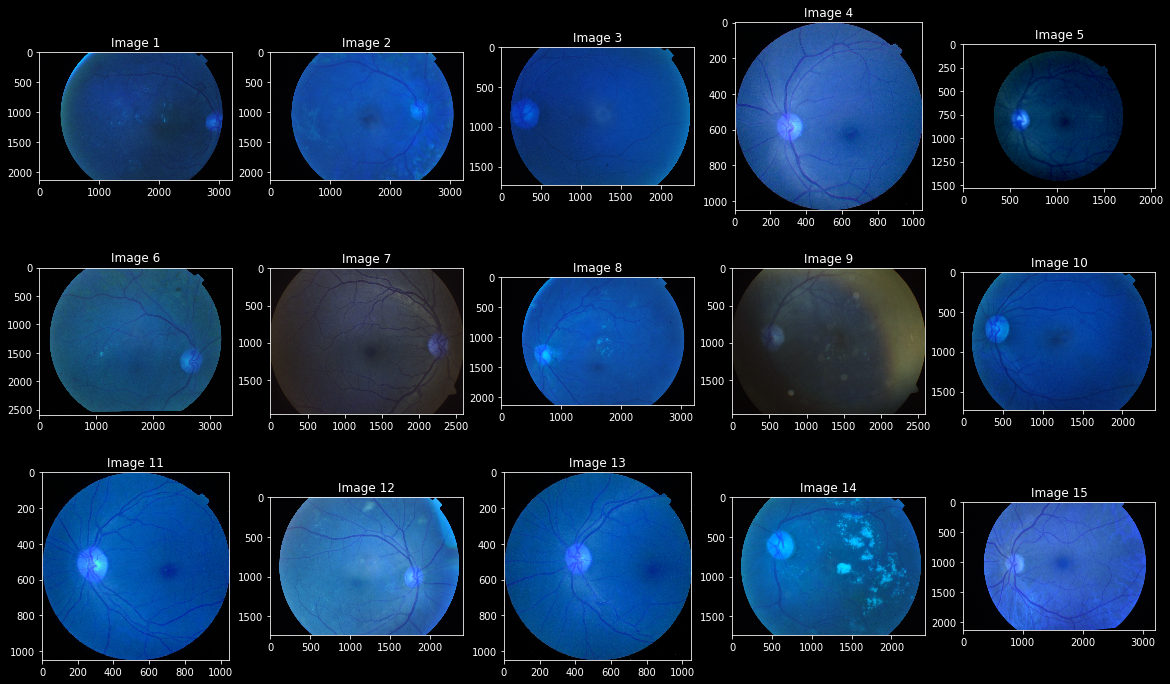

In [22]:
#sns.set_style('white')
plt.style.use('dark_background')
#plt.style.use('ggplot')
import cv2
count = 1
plt.figure(figsize=[20, 20])
for img_name in df_train['path'][0:15]:
    img = cv2.imread(img_name)
    plt.subplot(5,5,count)
    plt.imshow(img)
    plt.title('Image %s' % count)
    count += 1
    


3216 2136


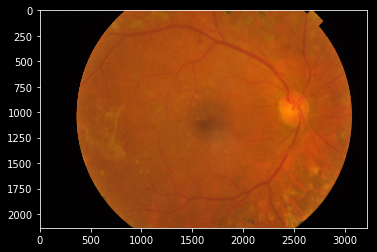

In [23]:
from PIL import Image

img = Image.open(df_train['path'][1])
width, height = img.size
print(width, height)
img.show()
plt.imshow(np.asarray(img))

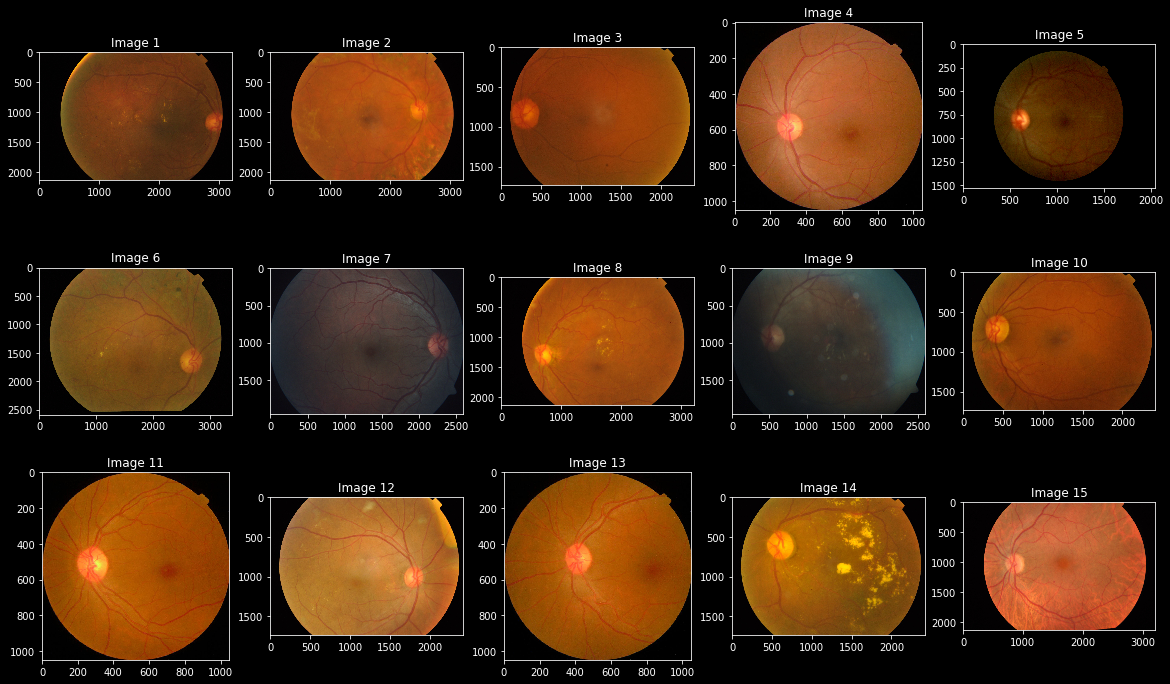

In [24]:
plt.figure(figsize=[20, 20])
count = 1
for img_name in df_train['path'][0:15]:
    img = Image.open(img_name)
    plt.subplot(5,5,count)
    plt.imshow(img)
    plt.title('Image %s' % count)
    count += 1

### Model Parameters

In [1]:
# Model parameters
BATCH_SIZE = 32
EPOCHS = 20
WARMUP_EPOCHS = 1
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 256
WIDTH = 256
CHANNEL = 3
N_CLASSES = df_train['diagnosis'].nunique()

ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5


                                                                                

NameError: name 'df_train' is not defined

In [26]:
# Preprocess data
df_test['id_file'] = df_test['id_code'].apply(lambda x: x + '.png')
df_test.head()

,id_code,id_file
0,0005cfc8afb6,0005cfc8afb6.png
1,003f0afdcd15,003f0afdcd15.png
2,006efc72b638,006efc72b638.png
3,00836aaacf06,00836aaacf06.png
4,009245722fa4,009245722fa4.png


In [27]:
### Data Generator
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255.,
                                   validation_split=0.2,
                                   horizontal_flip=True)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=train_dir,
    x_col='id_file',
    y_col='diagnosis',
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset='training')

valid_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=train_dir,
    x_col='id_file',
    y_col='diagnosis',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    target_size=(HEIGHT, WIDTH),
    subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory="./input/test_images/",
    x_col='id_file',
    target_size=(HEIGHT, WIDTH),
    batch_size=1,
    shuffle=False,
    class_mode=None)


Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


In [28]:
# from keras import optimizers, applications

# def create_model(input_shape, n_out):
# #    Resnet
# #    input_tensor = Input(shape=input_shape)
# #     base_model = applications.ResNet50(weights=None, 
# #                                        include_top=False,
# #                                        input_tensor=input_tensor)
# #     base_model.load_weights('./input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
#     base_model = applications.VGG16(weights='imagenet',
#                                    include_top=False,
#                                    input_shape=input_shape)
    
#     x = GlobalAveragePooling2D()(base_model.output)
#     x = Dropout(0.5)(x)
#     x = Dense(2048, activation='relu')(x)
#     x = Dropout(0.5)(x)
#     final_output = Dense(n_out, activation='softmax', name='final_output')(x)
#     model = Model(Input(input_shape), final_output)
    
#     return model

In [29]:
# from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, Flatten
# from keras.models import Sequential
# from keras import optimizers, applications
# import tensorflow as tf

# vgg16 = applications.VGG16(weights='imagenet',
#                                    include_top=False,
#                                    input_shape=(HEIGHT, WIDTH, CHANNEL))

# vgg16.summary()

In [30]:
import gc
gc.collect()

29134

In [33]:
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, Flatten
from keras.models import Sequential
from keras import optimizers, applications
from keras.applications import ResNet50
import tensorflow as tf

base_model = applications.ResNet50(weights=None,
                        include_top=False,
                        input_shape=(HEIGHT, WIDTH, CHANNEL))
base_model.load_weights('./input/models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
base_model.summary()

C:\Users\jaehy\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [34]:
# generator new model 
model = Sequential()
for layer in base_model.layers:
    layer.trainable = False

model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(N_CLASSES, activation='softmax'))#, name='final_output'))



In [35]:


metric_list = ["accuracy"]
# optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE)
# model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
# model.summary()
    

In [32]:
# STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
# STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

# history_warmup = model.fit_generator(generator=train_generator,
#                                     steps_per_epoch=STEP_SIZE_TRAIN,
#                                     validation_data=valid_generator,
#                                     validation_steps=STEP_SIZE_VALID,
#                                     epochs=WARMUP_EPOCHS,
#                                     verbose=1).history

In [41]:
# from keras.models import load_model

model.save(current_name('WORKING','-resnet50.h5'))
# model = load_model("./WORKING/190818a_initialization.h5")

.\WORKING\190821_075105-resnet50.h5


In [42]:
# from numba import cuda
# cuda.select_device(0)
# cuda.close()

Fine-Tune the complete model

In [43]:
STEP_SIZE_TRAIN = train_generator.n//BATCH_SIZE
STEP_SIZE_VALID = valid_generator.n//BATCH_SIZE

# for layer in model.layers:
#     layer.trainable = True
metric_list = ["accuracy"]
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, 
                   restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss',  mode='min', patience=RLROP_PATIENCE,
                          factor=DECAY_DROP, min_lr=1e-6, verbose=1)
callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metric_list)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 10245     
Total params: 27,794,309
Trainable params: 27,741,189
Non-trainable params: 53,120
___________________________________________________________

In [44]:
history_finetunning = model.fit_generator(generator=train_generator,
                                         steps_per_epoch=STEP_SIZE_TRAIN,
                                         validation_data=valid_generator,
                                         validation_steps=STEP_SIZE_VALID,
                                         epochs=EPOCHS,
                                         callbacks=callback_list,
                                         verbose=1).history

Epoch 1/20


ResourceExhaustedError: OOM when allocating tensor with shape[64,256,64,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node resnet50/add_3/add}} = Add[T=DT_FLOAT, _class=["loc:@training/Adam/gradients/AddN_152"], _device="/job:localhost/replica:0/task:0/device:GPU:0"](resnet50/bn2c_branch2c/cond/Merge, resnet50/activation_210/Relu)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node metrics/acc/Mean_1/_8283}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_19854_metrics/acc/Mean_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [ ]:
# from keras.models import load_model

model.save(current_name('WORKING','-resnet50.h5'))
# model = load_model("./WORKING/190818a_initialization.h5")

### Model loss graph

In [ ]:
# history = {'loss': history_warmup['loss'] + history_finetunning['loss'],
#            'val_loss':history_warmup['val_loss'] + history_finetunning['val_loss'],
#            'acc': history_warmup['acc'] + history_finetunning['acc'],
#            'val_acc': history_warmup['val_acc'] + history_finetunning['val_acc']}
history = {'loss': history_finetunning['loss'],
           'val_loss':history_finetunning['val_loss'],
           'acc':history_finetunning['acc'],
          'val_acc': history_finetunning['val_acc']}



#sns.set_style('whitegrid')

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(12,8))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['acc'], label='Train Accuracy')
ax2.plot(history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()






In [ ]:
# from numba import cuda
# cuda.select_device(0)
# cuda.close()

# import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.3
# set_session(tf.Session(config=config))

In [ ]:
os.listdir('./')

In [ ]:
from keras.models import load_model
model = load_model('./WORKING/190820_112603-vgg16.h5')

### Model Evaluation

In [ ]:
eval_datagen = ImageDataGenerator(rescale=1./255)
eval_generator = complete_datagen.flow_from_dataframe(
        dataframe=df_train,
        directory=train_dir,
        x_col='id_file',
        target_size=(HEIGHT, WIDTH),
        batch_size=11,
        shuffle=False,
        class_mode=None)


In [ ]:
len(eval_generator.filenames)

In [ ]:
predict = model.predict_generator(eval_generator, steps = eval_generator.n)

In [ ]:
print(complete_generator.n)

In [ ]:
STEP_SIZE_COMPLETE = complete_generator.n//1
train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE)
train_preds = [np.argmax(pred) for pred in train_preds]


In [ ]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(df_train['diagnosis'].astype('int'), train_preds)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [ ]:
print(df_train['diagnosis'].astype('int').shape)

print(len(train_preds))

In [ ]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, df_train['diagnosis'].astype('int'), weights='quadratic'))

### Apply model to test set and output prediction

In [ ]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST)
predictions = [np.argmax(pred) for pred in preds]

In [ ]:
filenames = test_generator.filenames
results = pd.DataFrame({'id_code':filenames, 'diagnosis':predictions})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])
results.to_csv('submission.csv',index=False)
results.head(10)

In [ ]:
results.to_csv(current_name('submission', '-submission.csv'),index=False)